<br>

In [312]:
# Tom Bresee
# Initial model - Random Forest Regressor
# Data:  Baseline (no loc features)
# Goal:  Tuning RandomForestRegressor scikit-learn mode

<br>

Found: the most important hyperparameter to be min samples leaf, followed by max features and number of estimators

<br>

In [156]:
# this notebook rendered in .html:

<br>

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<br>

*Utility Functions:*

In [157]:

def my_columns(df):
    """Print out columns from input dataframe"""
    for col in df.columns:
        print(col)
              
            
def my_null_per_col(column_name):
    print(df[column_name].isna().sum())
      
        
def my_null_all():
    """NaN for entire dataframe"""
    print(df.isna().sum())
    
    
def my_dup_rows_count():
    print(df.duplicated().sum())  
    # 1863 ? 
    
    
def kill_kolumns(list_of_columns):
    df.drop(list_of_columns, axis=1, inplace=True) 
    
    
def is_categorical(col):
    return df[col].dtype.name == 'object'


def quick_vc_bar(col):
    """ 
    input column
    output histogram of counts
    """
    print('Value Counts Histogram:', col)
    df[col].value_counts().plot(kind='bar', 
                                color='navy',
                                alpha=0.6,
                                figsize=(8,6))
    
def sort_my_df(df):
    df = df.sort_values(by='month', 
                              ascending=True).reset_index(drop=True)

    
def replace_values_in_col(col, mapping_dict):
    replace_values = mapping_dict
    df = df.replace({col: replace_values})

    
def the_columns(df):
    """sorted list of df columns"""
    for c in sorted(list(df.columns)):
        print(c)
        

def encode_and_bind(my_original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(my_original_dataframe[[feature_to_encode]])
    resulting_df = pd.concat([my_original_dataframe, dummies], axis=1)
    return(resulting_df)

# remove original feature at same time (slight variation):
# def encode_and_bind(original_dataframe, feature_to_encode):
#     dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     res = res.drop([feature_to_encode], axis=1)
#     return(res) 

# total number of NaNs completed summed in a pd df:
# df.isnull().sum().sum()

# df.transaction_id.value_counts()
# print(df.duplicated().sum())
# print(df.duplicated(keep='last'))
# print(df.duplicated().sum())
# 
# limit to categorical data using df.select_dtypes()
# X = X.select_dtypes(include=[object])

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# ohe.fit_transform()
# ohe.fit_transform(  df[['sex']])
# ohe.categories_

<br>

*Libraries:*

In [158]:
# --------------------------------------------------------------------------
from mycreds import creds_tom
# --------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# --------------------------------------------------------------------------
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------------------------------------------
import glob  
from datetime import datetime as dt
import pandas_profiling
from pandas_profiling import ProfileReport
# from bokeh.layouts import column
# from bokeh.models import Div, TeX
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# --------------------------------------------------------------------------
import fiona
from sqlalchemy import create_engine
# output_notebook() # bokeh
# --------------------------------------------------------------------------
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
cm = sns.light_palette("blue", as_cmap=True)
# correlations.style.set_caption('Correlation Values Ranked').background_gradient(cmap=cm)
# --------------------------------------------------------------------------
from pprint import pprint
import shap
shap.initjs()

In [291]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [292]:
import yellowbrick
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot

<br>

*Download raw data from AWS database:*

```
Database Views:
resale_price_norm  - transactions WITHOUT location features
resale_location_features  - transactions WITH location features
```

In [159]:
query = 'select * from resale_price_norm;'
engine = create_engine(f'postgresql+psycopg2://{creds_tom.username}:{creds_tom.password}@{creds_tom.host}/Capstone', echo=False)
sql_alc_cnxn = engine.connect()

In [160]:
df = pd.read_sql(query, sql_alc_cnxn)

In [161]:
original_number_of_observations = len(df)

In [162]:
original_number_of_observations

867677

In [163]:
len(df)  # ~ 867,677

867677

<br>

*Pickle if you want (in case no access to DB):*

In [91]:
df.to_pickle('resale_price_norm_11_backup_in_case_GOLD.pkl')  # ~ 232 MB
# compression  {‘infer’, ‘gzip’, ‘bz2’, ‘zip’, ‘xz’, None}
# will overwrite old file fyi 

*Read in previously downloaded .pkl of entire raw dataset, if desired:*

In [ ]:
# new_df = pd.read_pickle('resale_price_norm_GOLD.pkl')  

In [164]:
original_df = df.copy()

<br>

*Storing raw data (unfiltered) in parquet form:*

In [ ]:
#  df.to_parquet('df.parquet.gzip', compression='gzip') 
#  s3_url = 's3://bucket/folder/bucket.parquet.gzip'  
#  s3 bucket works as well

#  df.to_parquet(s3_url, compression='gzip')

In [12]:
df.to_parquet('df.parquet.gzip', compression='gzip')  
# parquet + compressed gzip form in the event files are huge
# and then can use: pd.read_parquet('df.parquet.gzip') to read the contents...

In [13]:
df.to_parquet('resale_price_norm_11_GOLD.parquet', engine='fastparquet')  
#  standard parquet form exported 

*Read-in parquet form (if needed):*

In [ ]:
# IF you wanted to read, and its pretty darn fast:
#  tf = pd.read_parquet('resale_price_norm_GOLD.parquet', engine='fastparquet') 

<br>

*Quick checks:*

In [165]:
df.dtypes

transaction_id                               object
month                                datetime64[ns]
block                                        object
town                                         object
street_name                                  object
address                                      object
storey_range                                 object
storey_range_min                              int64
storey_range_max                              int64
flat_model                                   object
flat_type                                    object
n_rooms                                       int64
floor_area_sqm                              float64
lease_commence_date                           int64
remaining_lease                              object
remaining_lease_years                         int64
remaining_lease_months                      float64
resale_price                                float64
price_per_sq_ft                             float64
price_per_sq

In [166]:
df.head(1).T  # random example datapoint 

,0
transaction_id,2004_06_545_WOODLANDS_DR_16_07_TO_09
month,2004-06-01 00:00:00
block,545
town,WOODLANDS
street_name,WOODLANDS DR 16
address,545 WOODLANDS DR 16
storey_range,07 TO 09
storey_range_min,7
storey_range_max,9
flat_model,Model A


<br>

*Timerange:*

In [167]:
df['month'] = pd.to_datetime(df['month'])
df = df.sort_values(by='month', ascending=True).reset_index(drop=True)  

def data_timeframe(df):
    print('\nNumber of rows of data: ............ ',len(df))  
    print('Most historic datapoint date: ...... ', df.month.iloc[0])
    print('Most recent datapoint date: ........ ', df.month.iloc[-1])
    print('Number of days of data: ............ ',(df.month.iloc[-1]-df.month.iloc[0])) 
    
data_timeframe(df)
# Number of rows of data: ............  867677
# Most historic datapoint date: ......  1990-01-01 00:00:00
# Most recent datapoint date: ........  2022-03-01 00:00:00
# Number of days of data: ............  11747 days 00:00:00


Number of rows of data: ............  867677
Most historic datapoint date: ......  1990-01-01 00:00:00
Most recent datapoint date: ........  2022-03-01 00:00:00
Number of days of data: ............  11747 days 00:00:00


<br>

*Singapore specifics (data integrity check usage possible):*

In [168]:
planning_areas = pd.read_html('https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore')[2]
planning_areas = planning_areas[['Name (English)', 'Region','Area (km²)', 'Population[7]', 'Density (/km²)']]
planning_areas.columns = ['Name', 'Region', 'Area_km2', 'Population', 'Density_per_km2']
planning_areas

,Name,Region,Area_km2,Population,Density_per_km2
0,Ang Mo Kio,North-East,13.94,163950,13400
1,Bedok,East,21.69,279380,13000
2,Bishan,Central,7.62,88010,12000
3,Boon Lay,West,8.23,30,3.6
4,Bukit Batok,West,11.13,153740,14000
5,Bukit Merah,Central,14.34,151980,11000
6,Bukit Panjang,West,8.99,139280,15000
7,Bukit Timah,Central,17.53,77430,4400
8,Central Water Catchment,North,37.15,*,*
9,Changi,East,40.61,1830,80.62


In [169]:
# https://en.wikipedia.org/wiki/Regions_of_Singapore
regions = pd.read_html('https://en.wikipedia.org/wiki/Regions_of_Singapore')[1]
regions.columns = ['Region', 'Regional Centre', 'Largest PA by area', 'Largest PA by population', 'Area(km²)', 
                   'Estimated Population', 'Populationdensity(/km²)', 'PlanningAreas']
regions = regions.iloc[:-1 , :]
regions

,Region,Regional Centre,Largest PA by area,Largest PA by population,Area(km²),Estimated Population,Populationdensity(/km²),PlanningAreas
0,Central Region,Central Area (de facto),Queenstown,Bukit Merah,132.70,922580,6952,22
1,East Region,Tampines,Changi,Bedok,93.10,685890,7367,6
2,North Region,Woodlands,Central Water Catchment,Woodlands,134.50,582330,4330,8
3,North-East Region,Seletar,North-Eastern Islands,Sengkang,103.90,930910,8960,9
4,West Region,Jurong East,Western Water Catchment,Jurong West,201.30,922540,4583,12


In [170]:
towns = pd.read_html('https://en.wikipedia.org/wiki/New_towns_of_Singapore')[0]

towns = towns[  ['Name (English/Malay)', 'Total area (km2)', 'Residential area (km2)', 
                 'Dwelling units', 'Projected ultimate', 'Population']]

towns.columns = ['Name', 'Total area (km2)', 'Residential area (km2)', 
                 'Dwelling units', 'Projected ultimate', 'Population']

towns

,Name,Total area (km2),Residential area (km2),Dwelling units,Projected ultimate,Population
0,Ang Mo Kio,6.38,2.83,50726,58000,138200
1,Bedok,9.37,4.18,62816,79000,187900
2,Bishan,6.90,1.72,20072,34000,61100
3,Bukit Batok,7.85,2.91,44285,54000,121400
4,Bukit Merah,8.58,3.12,54227,68000,141400
5,Bukit Panjang,4.89,2.19,35325,44000,118900
6,Choa Chu Kang,5.83,3.07,48900,62000,167200
7,Clementi,4.12,2.03,26730,39000,69500
8,Geylang,6.78,2.14,30892,50000,86000
9,Hougang,13.09,3.67,57272,72000,179700


In [171]:
estates = pd.read_html('https://en.wikipedia.org/wiki/New_towns_of_Singapore')[1]
estates = estates[['Name (English/Malay)', 'Dwelling units', 'Population']]
estates

,Name (English/Malay),Dwelling units,Population
0,Bukit Timah,2423,8100
1,Marine Parade,6537,20800
2,Central Area,9459,27200


<br>

*Cleaning:*

In [172]:
sorted(regions.Region.unique())  
# from scraped, as data integrity check ! 
# 

['Central Region',
 'East Region',
 'North Region',
 'North-East Region',
 'West Region']

In [173]:
# mapping towns -> region 
town_to_region_mapper = pd.Series(planning_areas.Region.values,
                                  index=planning_areas.Name).to_dict()
# town_to_region_mapper

In [174]:
## already exists:  'Kallang': 'Central', wtf 
town_to_region_mapper['Central Area'] = 'Central'  # obviously
town_to_region_mapper['Kallang/Whampoa'] = 'Central'
# sometimes the Kallang/Whampoa are reversed in order... 

In [175]:
# town_to_region_mapper  # note, will be longer than our unique towns

In [176]:
# towns.Name   # reference from previously scraped data, as quick reference

In [177]:
df['town'] = df['town'].str.title() 

In [178]:
# sorted(df.town.unique().tolist())  # 

In [179]:
df['region']= df['town'].map(town_to_region_mapper)

Value Counts Histogram: region


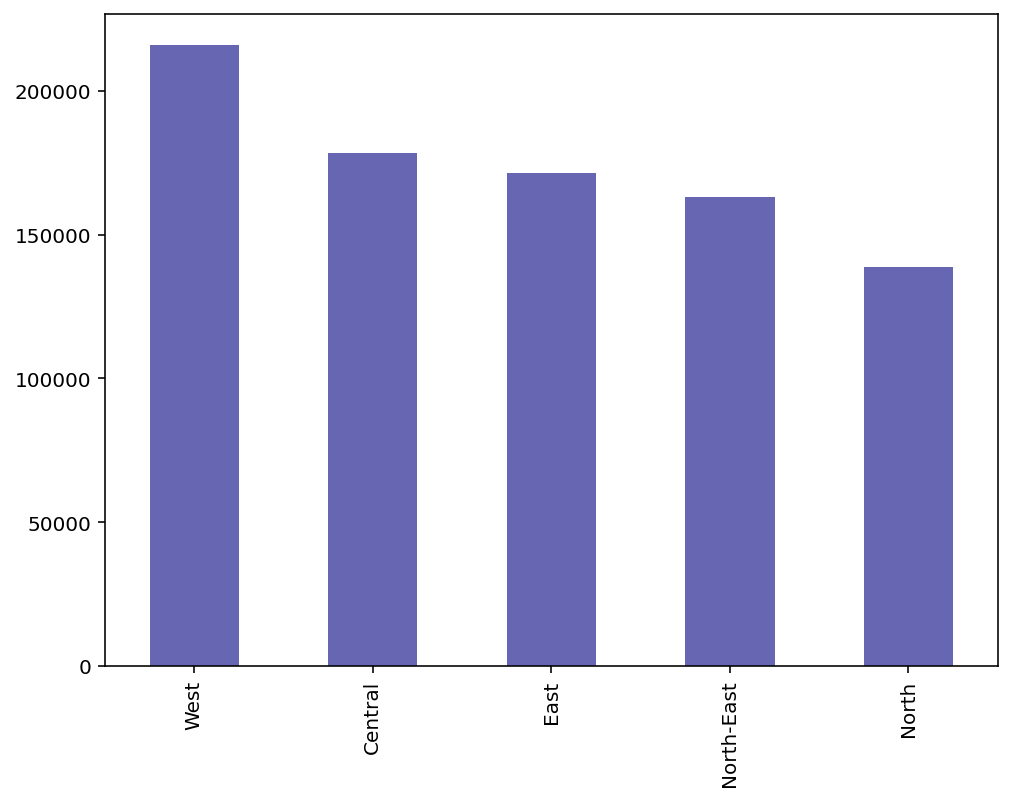

In [180]:
quick_vc_bar('region')

In [181]:
df.columns

Index(['transaction_id', 'month', 'block', 'town', 'street_name', 'address',
       'storey_range', 'storey_range_min', 'storey_range_max', 'flat_model',
       'flat_type', 'n_rooms', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease', 'remaining_lease_years', 'remaining_lease_months',
       'resale_price', 'price_per_sq_ft', 'price_per_sq_m',
       'price_per_sq_ft_per_lease_yr', 'price_per_sq_m_per_lease_yr',
       'resale_price_norm', 'price_per_sq_ft_norm',
       'price_per_sq_ft_per_lease_yr_norm', 'price_per_sq_m_norm',
       'price_per_sq_m_per_lease_yr_norm', 'region'],
      dtype='object')

In [182]:
df['flat_type'] = df['flat_type'].str.title()  

In [183]:
df.flat_type.unique().tolist() 
# 'Multi Generation' is the same as 'Multi-Generation' ?  i think so. 
# Need to figure out if 'Executive' is a suite, or is possible convert to 'floor' equivalent 

['5 Room',
 '3 Room',
 'Executive',
 '4 Room',
 '2 Room',
 '1 Room',
 'Multi Generation',
 'Multi-Generation']

In [184]:
df['flat_type'] = df['flat_type'].str.replace('Multi-Generation', 'Multi Generation', 
                                              regex=True) # they are the same thing 

In [185]:
# df.flat_type.unique().tolist() 

In [186]:
# df.n_rooms.isnull().sum() 
# did we set some already to a interpeted value ?   Yes

In [187]:
# adding new feature
df['storey_range_avg'] = (df['storey_range_min'] + df['storey_range_max'])/2

In [188]:
sorted(list(df.columns))

['address',
 'block',
 'flat_model',
 'flat_type',
 'floor_area_sqm',
 'lease_commence_date',
 'month',
 'n_rooms',
 'price_per_sq_ft',
 'price_per_sq_ft_norm',
 'price_per_sq_ft_per_lease_yr',
 'price_per_sq_ft_per_lease_yr_norm',
 'price_per_sq_m',
 'price_per_sq_m_norm',
 'price_per_sq_m_per_lease_yr',
 'price_per_sq_m_per_lease_yr_norm',
 'region',
 'remaining_lease',
 'remaining_lease_months',
 'remaining_lease_years',
 'resale_price',
 'resale_price_norm',
 'storey_range',
 'storey_range_avg',
 'storey_range_max',
 'storey_range_min',
 'street_name',
 'town',
 'transaction_id']

<br>

In [189]:
df['flat_model'] = df['flat_model'].str.lower()
df['flat_model'] = df['flat_model'].str.title() 

In [190]:
# sorted(df.flat_model.unique().tolist())
# we must assume these have many duplicated...
# i.e. IMPROVED actually equals Improved

# i dont like this. i feel like some of these apt types are 
# potentially subsets of other types of flat_models...
# consolidate somehow ? 

In [191]:
# df.flat_model.value_counts()
# when in doubt, see if the largest value counts dont have conflicting 
# flat_model types 

In [192]:
# df.flat_model.value_counts(normalize=True)

In [193]:
# sorted(list(df.lease_commence_date.unique()))

<br>

*Drop Duplicate Rows (initial):*

In [194]:
df.drop_duplicates(keep=False, inplace=True)

In [195]:
len(df)  # 863977

863977

In [196]:
original_number_of_observations

867677

In [197]:
original_number_of_observations - len(df)

3700

In [198]:
sorted(df.columns.to_list())

['address',
 'block',
 'flat_model',
 'flat_type',
 'floor_area_sqm',
 'lease_commence_date',
 'month',
 'n_rooms',
 'price_per_sq_ft',
 'price_per_sq_ft_norm',
 'price_per_sq_ft_per_lease_yr',
 'price_per_sq_ft_per_lease_yr_norm',
 'price_per_sq_m',
 'price_per_sq_m_norm',
 'price_per_sq_m_per_lease_yr',
 'price_per_sq_m_per_lease_yr_norm',
 'region',
 'remaining_lease',
 'remaining_lease_months',
 'remaining_lease_years',
 'resale_price',
 'resale_price_norm',
 'storey_range',
 'storey_range_avg',
 'storey_range_max',
 'storey_range_min',
 'street_name',
 'town',
 'transaction_id']

<br>

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
# %config InlineBackend.figure_format = 'retina'
# plt.rcParams['savefig.facecolor']='white'

# plt.figure(figsize=(12,12))

# sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), 
#                  fmt='.2g', 
#                  annot = True, 
#                  vmin=-1,
#                  vmax=1, 
#                  center= 0, 
#                  cmap= 'seismic', 
#                  linecolor='black', 
#                  linewidth=.5, 
#                  annot_kws={"size": 9})

# plt.xticks(rotation=45, 
#            ha='right')

# plt.title('\nSingapore HDB Correlation Matrix\n',
#           fontsize=13)

# # plt.savefig('correlation_matrix_baseline.png', 
# #             bbox_inches='tight',
# #             pad_inches=0.2, 
# #             dpi=400)
# plt.show();

In [201]:
# # let's rank from highest to lowest (comparing to our price_per_sq_m_norm feature)
# correlations = df.corr()
# correlations = correlations[['price_per_sq_m_norm']].sort_values(by='price_per_sq_m_norm', 
#                                                                  ascending=False)
# print(correlations.to_string())

In [202]:
# cm = sns.light_palette("blue", as_cmap=True)
# correlations.style.set_caption('Correlation Values Ranked').background_gradient(cmap=cm)

### Encoding

In [203]:
df_ml = df.copy()
# YOU CAN GO BACK TO THIS POINT IF YOU MESS UP

In [204]:
the_columns(df_ml)  
# before 

address
block
flat_model
flat_type
floor_area_sqm
lease_commence_date
month
n_rooms
price_per_sq_ft
price_per_sq_ft_norm
price_per_sq_ft_per_lease_yr
price_per_sq_ft_per_lease_yr_norm
price_per_sq_m
price_per_sq_m_norm
price_per_sq_m_per_lease_yr
price_per_sq_m_per_lease_yr_norm
region
remaining_lease
remaining_lease_months
remaining_lease_years
resale_price
resale_price_norm
storey_range
storey_range_avg
storey_range_max
storey_range_min
street_name
town
transaction_id


In [205]:
def encode_and_bind(my_original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(my_original_dataframe[[feature_to_encode]], 
                            prefix_sep='_')
    resulting_df = pd.concat([my_original_dataframe, dummies], axis=1)
    return(resulting_df)

In [206]:
df_ml.dtypes  # before 

transaction_id                               object
month                                datetime64[ns]
block                                        object
town                                         object
street_name                                  object
address                                      object
storey_range                                 object
storey_range_min                              int64
storey_range_max                              int64
flat_model                                   object
flat_type                                    object
n_rooms                                       int64
floor_area_sqm                              float64
lease_commence_date                           int64
remaining_lease                              object
remaining_lease_years                         int64
remaining_lease_months                      float64
resale_price                                float64
price_per_sq_ft                             float64
price_per_sq

In [207]:
df_ml = encode_and_bind(df_ml, 'region')
df_ml = encode_and_bind(df_ml, 'town')
df_ml = encode_and_bind(df_ml, 'flat_model')
df_ml = encode_and_bind(df_ml, 'flat_type')
df_ml = encode_and_bind(df_ml, 'storey_range')

In [208]:
# all_columns = sorted(df_ml.columns)
# all_columns

In [209]:
all_hot_encoded_columns = ['flat_model_2-Room',
 'flat_model_Adjoined Flat',
 'flat_model_Apartment',
 'flat_model_Dbss',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation',
 'flat_model_New Generation',
 'flat_model_Premium Apartment',
 'flat_model_Premium Apartment Loft',
 'flat_model_Premium Maisonette',
 'flat_model_Simplified',
 'flat_model_Standard',
 'flat_model_Terrace',
 'flat_model_Type S1',
 'flat_model_Type S2',
                           
 'flat_type_1 Room',
 'flat_type_2 Room',
 'flat_type_3 Room',
 'flat_type_4 Room',
 'flat_type_5 Room',
 'flat_type_Executive',
 'flat_type_Multi Generation',
                           
 'region_Central',
 'region_East',
 'region_North',
 'region_North-East',
 'region_West',
                           
 'storey_range_01 TO 03',
 'storey_range_01 TO 05',
 'storey_range_04 TO 06',
 'storey_range_06 TO 10',
 'storey_range_07 TO 09',
 'storey_range_10 TO 12',
 'storey_range_11 TO 15',
 'storey_range_13 TO 15',
 'storey_range_16 TO 18',
 'storey_range_16 TO 20',
 'storey_range_19 TO 21',
 'storey_range_21 TO 25',
 'storey_range_22 TO 24',
 'storey_range_25 TO 27',
 'storey_range_26 TO 30',
 'storey_range_28 TO 30',
 'storey_range_31 TO 33',
 'storey_range_31 TO 35',
 'storey_range_34 TO 36',
 'storey_range_36 TO 40',
 'storey_range_37 TO 39',
 'storey_range_40 TO 42',
 'storey_range_43 TO 45',
 'storey_range_46 TO 48',
 'storey_range_49 TO 51',
                           
 'town_Ang Mo Kio',
 'town_Bedok',
 'town_Bishan',
 'town_Bukit Batok',
 'town_Bukit Merah',
 'town_Bukit Panjang',
 'town_Bukit Timah',
 'town_Central Area',
 'town_Choa Chu Kang',
 'town_Clementi',
 'town_Geylang',
 'town_Hougang',
 'town_Jurong East',
 'town_Jurong West',
 'town_Kallang/Whampoa',
 'town_Lim Chu Kang',
 'town_Marine Parade',
 'town_Pasir Ris',
 'town_Punggol',
 'town_Queenstown',
 'town_Sembawang',
 'town_Sengkang',
 'town_Serangoon',
 'town_Tampines',
 'town_Toa Payoh',
 'town_Woodlands',
 'town_Yishun']


In [210]:

all_unencoded_columns =  ['address',
 'floor_area_sqm',
 'lease_commence_date',
 'month',
 'n_rooms',
 'price_per_sq_ft',
 'price_per_sq_ft_norm',
 'price_per_sq_ft_per_lease_yr',
 'price_per_sq_ft_per_lease_yr_norm',
 'price_per_sq_m',
 'price_per_sq_m_norm',
 'price_per_sq_m_per_lease_yr',
 'price_per_sq_m_per_lease_yr_norm',
 'remaining_lease_years',
 'resale_price_norm',
 'storey_range_avg',
 'storey_range_max',
 'storey_range_min']


In [211]:
sorted(list(df_ml.columns))

['address',
 'block',
 'flat_model',
 'flat_model_2-Room',
 'flat_model_Adjoined Flat',
 'flat_model_Apartment',
 'flat_model_Dbss',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation',
 'flat_model_New Generation',
 'flat_model_Premium Apartment',
 'flat_model_Premium Apartment Loft',
 'flat_model_Premium Maisonette',
 'flat_model_Simplified',
 'flat_model_Standard',
 'flat_model_Terrace',
 'flat_model_Type S1',
 'flat_model_Type S2',
 'flat_type',
 'flat_type_1 Room',
 'flat_type_2 Room',
 'flat_type_3 Room',
 'flat_type_4 Room',
 'flat_type_5 Room',
 'flat_type_Executive',
 'flat_type_Multi Generation',
 'floor_area_sqm',
 'lease_commence_date',
 'month',
 'n_rooms',
 'price_per_sq_ft',
 'price_per_sq_ft_norm',
 'price_per_sq_ft_per_lease_yr',
 'price_per_sq_ft_per_lease_yr_norm',
 'price_per_sq_m',
 'price_per_sq_m_norm',
 'price_per_sq_m_

In [212]:

full_columns_to_keep = ['flat_model_2-Room',
 'flat_model_Adjoined Flat',
 'flat_model_Apartment',
 'flat_model_Dbss',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation',
 'flat_model_New Generation',
 'flat_model_Premium Apartment',
 'flat_model_Premium Apartment Loft',
 'flat_model_Premium Maisonette',
 'flat_model_Simplified',
 'flat_model_Standard',
 'flat_model_Terrace',
 'flat_model_Type S1',
 'flat_model_Type S2',

 'flat_type_1 Room',
 'flat_type_2 Room',
 'flat_type_3 Room',
 'flat_type_4 Room',
 'flat_type_5 Room',
 'flat_type_Executive',
 'flat_type_Multi Generation',

 'floor_area_sqm',
 
 'lease_commence_date',
 
 'month', 

 'n_rooms',
 
 'price_per_sq_m_per_lease_yr_norm',

 'region_Central',
 'region_East',
 'region_North',
 'region_North-East',
 'region_West',

 'remaining_lease_years',

 'storey_range_01 TO 03',
 'storey_range_01 TO 05',
 'storey_range_04 TO 06',
 'storey_range_06 TO 10',
 'storey_range_07 TO 09',
 'storey_range_10 TO 12',
 'storey_range_11 TO 15',
 'storey_range_13 TO 15',
 'storey_range_16 TO 18',
 'storey_range_16 TO 20',
 'storey_range_19 TO 21',
 'storey_range_21 TO 25',
 'storey_range_22 TO 24',
 'storey_range_25 TO 27',
 'storey_range_26 TO 30',
 'storey_range_28 TO 30',
 'storey_range_31 TO 33',
 'storey_range_31 TO 35',
 'storey_range_34 TO 36',
 'storey_range_36 TO 40',
 'storey_range_37 TO 39',
 'storey_range_40 TO 42',
 'storey_range_43 TO 45',
 'storey_range_46 TO 48',
 'storey_range_49 TO 51',

 'storey_range_avg',
 'storey_range_max',
 'storey_range_min',
 
 'town_Ang Mo Kio',
 'town_Bedok',
 'town_Bishan',
 'town_Bukit Batok',
 'town_Bukit Merah',
 'town_Bukit Panjang',
 'town_Bukit Timah',
 'town_Central Area',
 'town_Choa Chu Kang',
 'town_Clementi',
 'town_Geylang',
 'town_Hougang',
 'town_Jurong East',
 'town_Jurong West',
 'town_Kallang/Whampoa',
 'town_Lim Chu Kang',
 'town_Marine Parade',
 'town_Pasir Ris',
 'town_Punggol',
 'town_Queenstown',
 'town_Sembawang',
 'town_Sengkang',
 'town_Serangoon',
 'town_Tampines',
 'town_Toa Payoh',
 'town_Woodlands',
 'town_Yishun']


In [213]:
df_ml_1 = df_ml[full_columns_to_keep]

---

# Building Machine Learning Models

---

### Random Forest Regressor

In [214]:

# to be safe 

df_ml_1 = df_ml_1.sort_values(by='month', 
                              ascending=True).reset_index(drop=True)


In [215]:
del df_ml_1['month']  # and now you will split from here 

In [216]:
df_ml_1.dtypes

flat_model_2-Room                      uint8
flat_model_Adjoined Flat               uint8
flat_model_Apartment                   uint8
flat_model_Dbss                        uint8
flat_model_Improved                    uint8
flat_model_Improved-Maisonette         uint8
flat_model_Maisonette                  uint8
flat_model_Model A                     uint8
flat_model_Model A-Maisonette          uint8
flat_model_Model A2                    uint8
flat_model_Multi Generation            uint8
flat_model_New Generation              uint8
flat_model_Premium Apartment           uint8
flat_model_Premium Apartment Loft      uint8
flat_model_Premium Maisonette          uint8
flat_model_Simplified                  uint8
flat_model_Standard                    uint8
flat_model_Terrace                     uint8
flat_model_Type S1                     uint8
flat_model_Type S2                     uint8
flat_type_1 Room                       uint8
flat_type_2 Room                       uint8
flat_type_

---

In [243]:
df_ml_2 = df_ml_1.copy()

In [244]:
df_ml_2.dtypes

flat_model_2-Room                      uint8
flat_model_Adjoined Flat               uint8
flat_model_Apartment                   uint8
flat_model_Dbss                        uint8
flat_model_Improved                    uint8
flat_model_Improved-Maisonette         uint8
flat_model_Maisonette                  uint8
flat_model_Model A                     uint8
flat_model_Model A-Maisonette          uint8
flat_model_Model A2                    uint8
flat_model_Multi Generation            uint8
flat_model_New Generation              uint8
flat_model_Premium Apartment           uint8
flat_model_Premium Apartment Loft      uint8
flat_model_Premium Maisonette          uint8
flat_model_Simplified                  uint8
flat_model_Standard                    uint8
flat_model_Terrace                     uint8
flat_model_Type S1                     uint8
flat_model_Type S2                     uint8
flat_type_1 Room                       uint8
flat_type_2 Room                       uint8
flat_type_

In [245]:
# --- passes ---

# dff = df_ml_2.copy()

# X_initial = dff.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
# X = X_initial.values

# y = dff['price_per_sq_m_per_lease_yr_norm'].values

# eighty_percent = 0.8 * len(dff)
# ninety_percent = 0.9 * len(dff)

# X_train= X[:round(eighty_percent)]
# X_val  = X[round(eighty_percent):round(ninety_percent)]
# X_test = X[round(ninety_percent):]

# y_train= y[:round(eighty_percent)]
# y_val  = y[round(eighty_percent):round(ninety_percent)]
# y_test = y[round(ninety_percent):]

# assert ( (len(X_train) + len(X_val) + len(X_test)) == (len(y_train) + len(y_val) + len(y_test)))
# assert ( (len(X_train) + len(X_val) + len(X_test)) == len(dff))

In [252]:

def model_base_random_forest(df):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    
    y = df['price_per_sq_m_per_lease_yr_norm'].values

    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]

    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               # n_estimators=50,
                               # max_depth=8,
                               n_jobs=-1)                   
    
    rfModel = rf.fit(X_train, y_train)
    
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
        
    print('\n')

    print('--- Test Set ---')
    
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))

    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
   
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
        
    print('Score ..................', rfModel.score(X_test, y_test))
    
    print('\n')

    print('--- Val Set ---')
    
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))

    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
   
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
        
    print('Score ..................', rfModel.score(X_val, y_val))
        
    print('\n')

    print('--- Train Set ---')
    
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
              
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
          
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
   
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
        
    print('Score ..................', rfModel.score(X_train, y_train))
        
    print('\n\n')
    
    print('sns.distplot((y_test-y_pred_test)):')
    
    sns.distplot((y_test-y_pred_test))
    
    # guess vs reality plot horizontal 
    #     plt.figure(figsize=(12,8))
    #     plt.plot(y_test, color='red')
    #     plt.plot(y_pred, color='blue')
    #     plt.show()

    plt.figure(figsize = (5,5), dpi=100)
    plt.scatter(y_test,y_pred_test, s=0.5, alpha=.7, color='green')
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()
    
    importances = rfModel.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = np.array(list(X_initial))
    # print(importances)
    
    # Print the feature ranking
    print("\nFeature ranking:")
        
    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))
            
    # Look at parameters used by our current forest
    print('\nParameters currently in use:')
    pprint(rfModel.get_params())


---

Scenario = `All initial features included`



--- Test Set ---
Mean Absolute Error: ... 8.357162271222794
Mean Squared Error:..... 130.55
RMSE: .................. 11.425767101909685
Coeff of det (R^2):..... 0.632
Score .................. 0.632494511902248


--- Val Set ---
Mean Absolute Error: ... 6.100667344213111
Mean Squared Error:..... 72.70
RMSE: .................. 8.526359567451005
Coeff of det (R^2):..... 0.808
Score .................. 0.8075049844491826


--- Train Set ---
Mean Absolute Error: ... 2.580256332763297
Mean Squared Error:..... 14.41
RMSE: .................. 3.796519720505646
Coeff of det (R^2):..... 0.931
Score .................. 0.9309287194565808



sns.distplot((y_test-y_pred_test)):


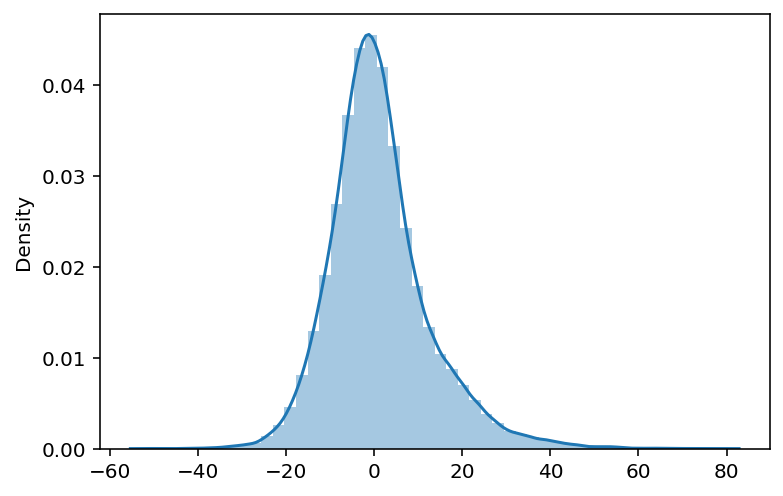

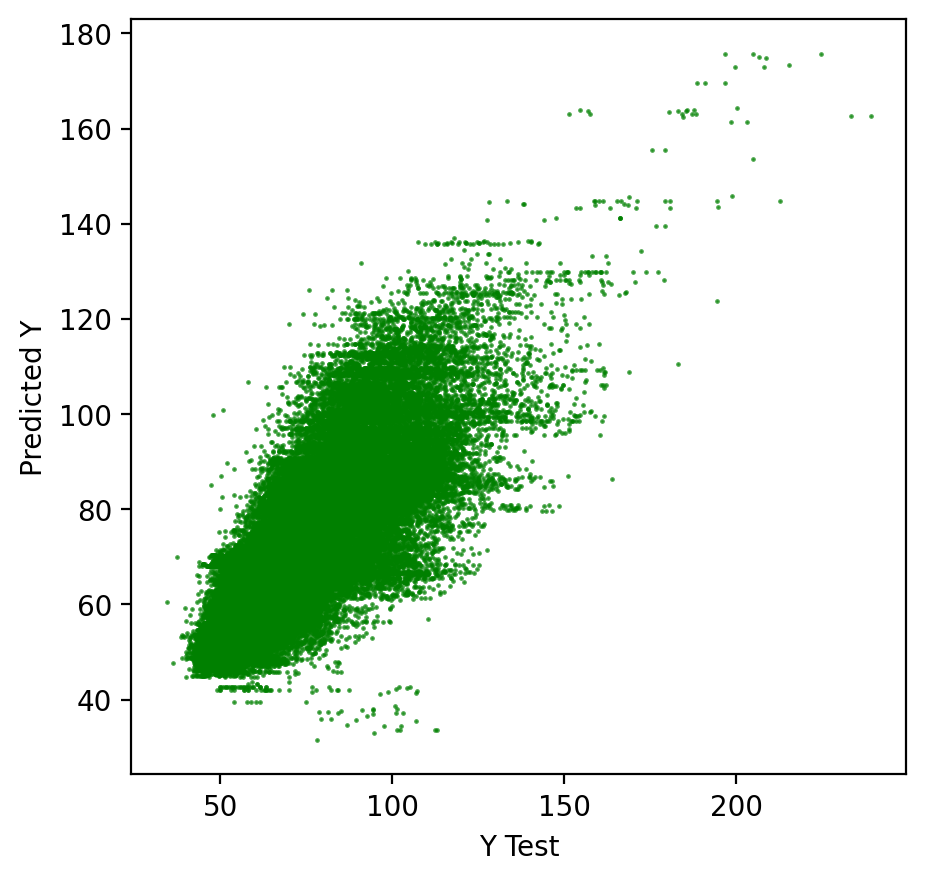


Feature ranking:
1. remaining_lease_years (0.390043)
2. lease_commence_date (0.123677)
3. region_Central (0.100067)
4. floor_area_sqm (0.091946)
5. n_rooms (0.089017)
6. region_North (0.019850)
7. region_West (0.012137)
8. storey_range_avg (0.011040)
9. storey_range_min (0.010964)
10. town_Clementi (0.010806)
11. town_Marine Parade (0.008809)
12. region_East (0.008231)
13. town_Jurong West (0.007884)
14. storey_range_max (0.007747)
15. town_Central Area (0.006557)
16. flat_type_Executive (0.005931)
17. town_Tampines (0.005580)
18. town_Geylang (0.005375)
19. town_Bukit Merah (0.004739)
20. flat_model_Terrace (0.004724)
21. flat_type_4 Room (0.004690)
22. flat_model_Improved (0.004671)
23. town_Queenstown (0.004370)
24. flat_model_Standard (0.003910)
25. town_Choa Chu Kang (0.003879)
26. town_Ang Mo Kio (0.003822)
27. town_Woodlands (0.003804)
28. town_Jurong East (0.003732)
29. town_Toa Payoh (0.002838)
30. town_Bukit Batok (0.002778)
31. flat_model_New Generation (0.002671)
32. town_

In [253]:
model_base_random_forest(df_ml_2)

<br><br><br>

Scenario = `Remove hot encoded storey ranges.`

In [254]:
c2u = full_columns_to_keep = ['flat_model_2-Room',
 'flat_model_Adjoined Flat',
 'flat_model_Apartment',
 'flat_model_Dbss',
 'flat_model_Improved',
 'flat_model_Improved-Maisonette',
 'flat_model_Maisonette',
 'flat_model_Model A',
 'flat_model_Model A-Maisonette',
 'flat_model_Model A2',
 'flat_model_Multi Generation',
 'flat_model_New Generation',
 'flat_model_Premium Apartment',
 'flat_model_Premium Apartment Loft',
 'flat_model_Premium Maisonette',
 'flat_model_Simplified',
 'flat_model_Standard',
 'flat_model_Terrace',
 'flat_model_Type S1',
 'flat_model_Type S2',

 'flat_type_1 Room',
 'flat_type_2 Room',
 'flat_type_3 Room',
 'flat_type_4 Room',
 'flat_type_5 Room',
 'flat_type_Executive',
 'flat_type_Multi Generation',

 'floor_area_sqm',
 
 'lease_commence_date',
 
 'n_rooms',
 
 'price_per_sq_m_per_lease_yr_norm',

 'region_Central',
 'region_East',
 'region_North',
 'region_North-East',
 'region_West',

 'remaining_lease_years',

#  'storey_range_01 TO 03',
#  'storey_range_01 TO 05',
#  'storey_range_04 TO 06',
#  'storey_range_06 TO 10',
#  'storey_range_07 TO 09',
#  'storey_range_10 TO 12',
#  'storey_range_11 TO 15',
#  'storey_range_13 TO 15',
#  'storey_range_16 TO 18',
#  'storey_range_16 TO 20',
#  'storey_range_19 TO 21',
#  'storey_range_21 TO 25',
#  'storey_range_22 TO 24',
#  'storey_range_25 TO 27',
#  'storey_range_26 TO 30',
#  'storey_range_28 TO 30',
#  'storey_range_31 TO 33',
#  'storey_range_31 TO 35',
#  'storey_range_34 TO 36',
#  'storey_range_36 TO 40',
#  'storey_range_37 TO 39',
#  'storey_range_40 TO 42',
#  'storey_range_43 TO 45',
#  'storey_range_46 TO 48',
#  'storey_range_49 TO 51',

 'storey_range_avg',
 'storey_range_max',
 'storey_range_min',
 
 'town_Ang Mo Kio',
 'town_Bedok',
 'town_Bishan',
 'town_Bukit Batok',
 'town_Bukit Merah',
 'town_Bukit Panjang',
 'town_Bukit Timah',
 'town_Central Area',
 'town_Choa Chu Kang',
 'town_Clementi',
 'town_Geylang',
 'town_Hougang',
 'town_Jurong East',
 'town_Jurong West',
 'town_Kallang/Whampoa',
 'town_Lim Chu Kang',
 'town_Marine Parade',
 'town_Pasir Ris',
 'town_Punggol',
 'town_Queenstown',
 'town_Sembawang',
 'town_Sengkang',
 'town_Serangoon',
 'town_Tampines',
 'town_Toa Payoh',
 'town_Woodlands',
 'town_Yishun']
    

In [255]:
df_ml_3= df_ml_1[c2u]



--- Test Set ---
Mean Absolute Error: ... 8.364830370976636
Mean Squared Error:..... 130.53
RMSE: .................. 11.425164080573788
Coeff of det (R^2):..... 0.633
Score .................. 0.6325333027861018


--- Val Set ---
Mean Absolute Error: ... 6.107622067257306
Mean Squared Error:..... 72.91
RMSE: .................. 8.538690998417009
Coeff of det (R^2):..... 0.807
Score .................. 0.8069477816917059


--- Train Set ---
Mean Absolute Error: ... 2.5799769958716667
Mean Squared Error:..... 14.41
RMSE: .................. 3.7966178831363036
Coeff of det (R^2):..... 0.931
Score .................. 0.9309251476030125



sns.distplot((y_test-y_pred_test)):


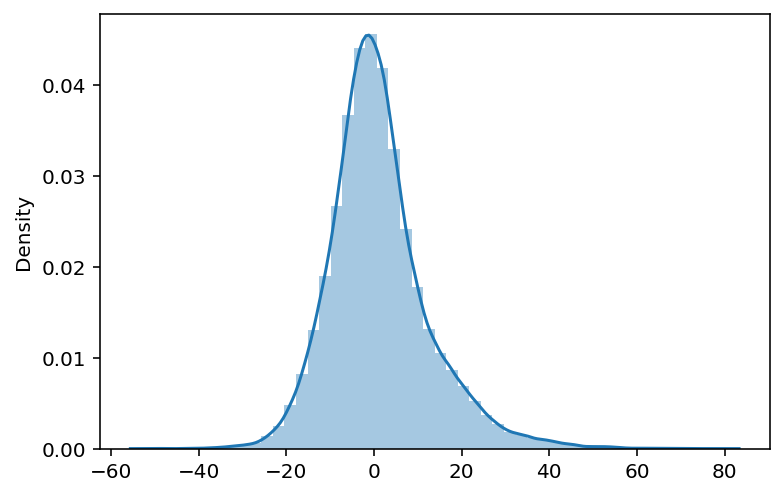

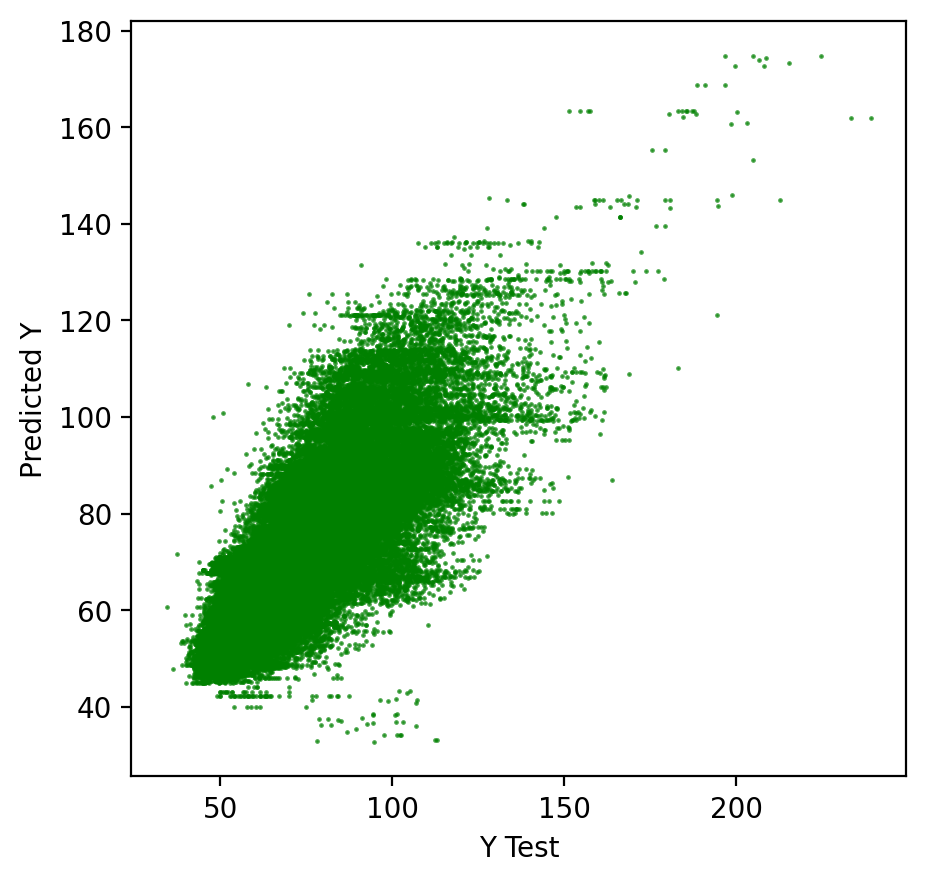


Feature ranking:
1. remaining_lease_years (0.390157)
2. lease_commence_date (0.123733)
3. region_Central (0.100095)
4. floor_area_sqm (0.092045)
5. n_rooms (0.089452)
6. region_North (0.019923)
7. storey_range_avg (0.014181)
8. storey_range_min (0.013310)
9. region_West (0.012229)
10. town_Clementi (0.010826)
11. storey_range_max (0.010374)
12. town_Marine Parade (0.008808)
13. region_East (0.008163)
14. town_Jurong West (0.007750)
15. town_Central Area (0.006550)
16. flat_type_Executive (0.005923)
17. town_Tampines (0.005586)
18. town_Geylang (0.005379)
19. town_Bukit Merah (0.004743)
20. flat_model_Terrace (0.004738)
21. flat_model_Improved (0.004729)
22. flat_type_4 Room (0.004518)
23. town_Queenstown (0.004377)
24. flat_model_Standard (0.003931)
25. town_Choa Chu Kang (0.003870)
26. town_Ang Mo Kio (0.003825)
27. town_Jurong East (0.003739)
28. town_Woodlands (0.003719)
29. town_Toa Payoh (0.002835)
30. town_Bukit Batok (0.002781)
31. flat_model_New Generation (0.002621)
32. town_

In [256]:
model_base_random_forest(df_ml_3)

<br><br><br>

Scenario = `initial manual tuning of the random forest regressor alg`

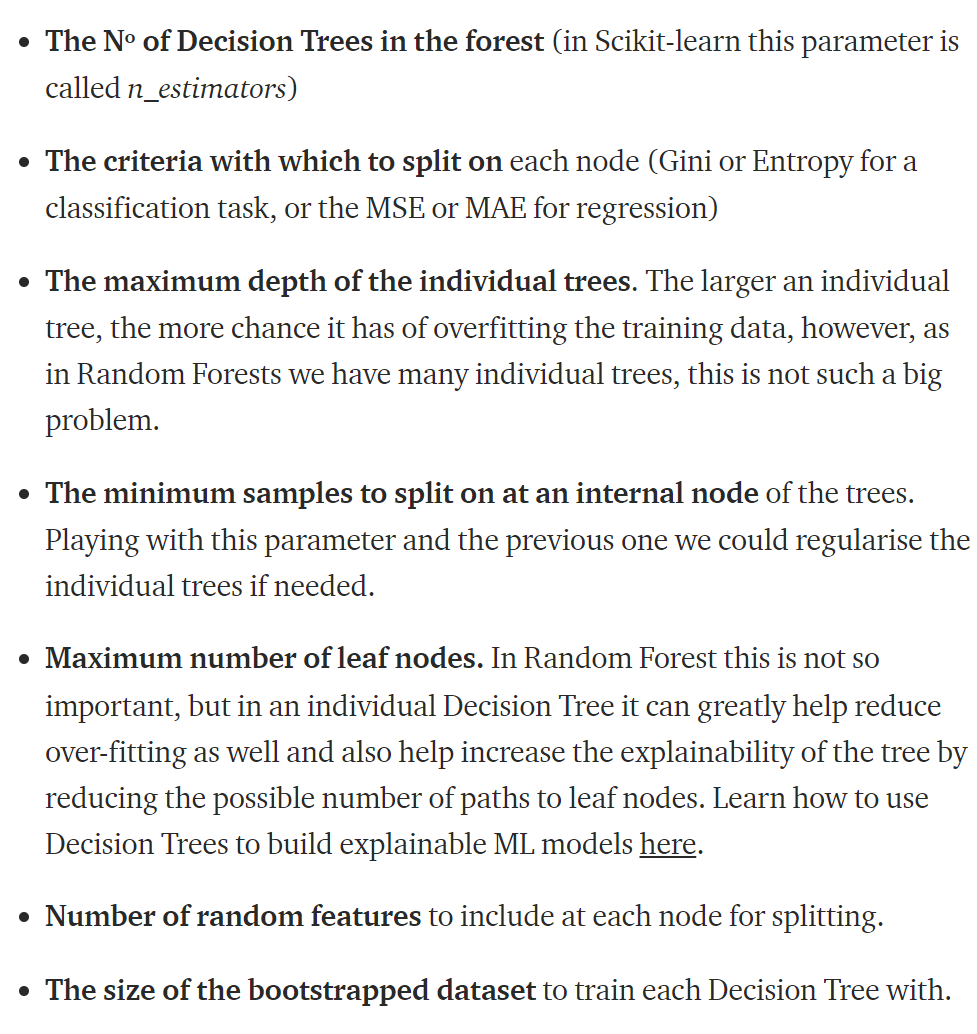

```
Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  
 'max_features': 'auto',  If “auto”, then max_features=n_features.

 'max_depth': None, The maximum depth of the tree. 
  If None, then nodes are expanded until all leaves
  are pure or until all leaves contain less than min_samples_split samples.
  
 'max_leaf_nodes': None,
 
 'max_samples': None,
 
 'min_samples_leaf': 1,
 
 'min_samples_split': 2,
 
 'min_weight_fraction_leaf': 0.0,
 
 'n_estimators': 100,
 
 'oob_score': False,
 
 'warm_start': False}
```

In [258]:

def model_2(df):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=1, 
                               n_estimators=200,
                               # max_depth=8,
                               n_jobs=-1)                   
    
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
    print('\n')
    print('--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    print('Score ..................', rfModel.score(X_test, y_test))
    print('\n')
    print('--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    print('Score ..................', rfModel.score(X_val, y_val))
    print('\n')
    print('--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    print('Score ..................', rfModel.score(X_train, y_train))
    print('\n\n')
    print('sns.distplot((y_test-y_pred_test)):')
    sns.distplot((y_test-y_pred_test))
    #     guess vs reality plot horizontal 
    #         plt.figure(figsize=(12,8))
    #         plt.plot(y_test, color='red')
    #         plt.plot(y_pred, color='blue')
    #         plt.show()
    plt.figure(figsize = (5,5), dpi=100)
    plt.scatter(y_test,y_pred_test, s=0.5, alpha=.7, color='green')
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()
    
    importances = rfModel.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = np.array(list(X_initial))
    # print(importances)
    # Print the feature ranking
    print("\nFeature ranking:")
    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))  
    # Look at parameters used by our current forest
    print('\nParameters currently in use:')
    pprint(rfModel.get_params())
    
    # the power of 24 cores... 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Do



--- Test Set ---
Mean Absolute Error: ... 8.356261372059944
Mean Squared Error:..... 130.50
RMSE: .................. 11.423510264354874
Coeff of det (R^2):..... 0.633


[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.


Score .................. 0.632639678221052


--- Val Set ---
Mean Absolute Error: ... 6.103635470304361
Mean Squared Error:..... 72.78
RMSE: .................. 8.531157779679036
Coeff of det (R^2):..... 0.807


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.5s finished


Score .................. 0.8072882701956348


--- Train Set ---
Mean Absolute Error: ... 2.5774123848898305
Mean Squared Error:..... 14.38
RMSE: .................. 3.7917507298223283
Coeff of det (R^2):..... 0.931


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    7.3s finished


Score .................. 0.9311021379713629



sns.distplot((y_test-y_pred_test)):


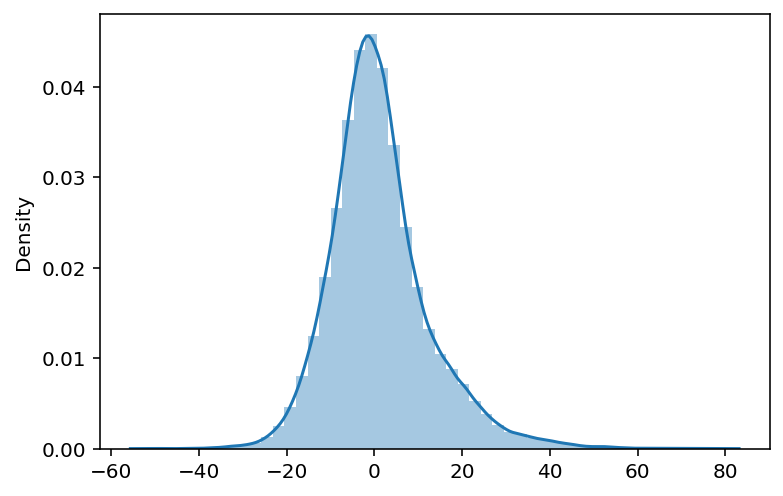

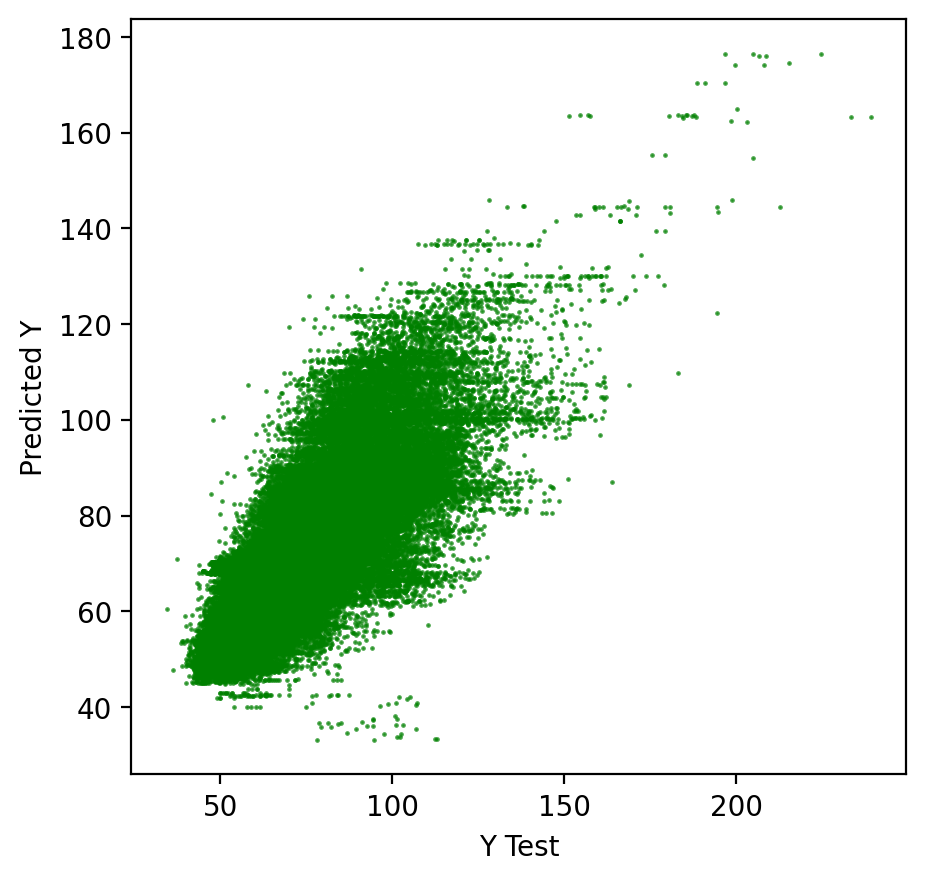


Feature ranking:
1. remaining_lease_years (0.390297)
2. lease_commence_date (0.123621)
3. region_Central (0.100155)
4. floor_area_sqm (0.092152)
5. n_rooms (0.089322)
6. region_North (0.020013)
7. storey_range_avg (0.013814)
8. storey_range_min (0.013564)
9. region_West (0.012346)
10. town_Clementi (0.010803)
11. storey_range_max (0.010517)
12. town_Marine Parade (0.008834)
13. region_East (0.008119)
14. town_Jurong West (0.007711)
15. town_Central Area (0.006561)
16. flat_type_Executive (0.005892)
17. town_Tampines (0.005620)
18. town_Geylang (0.005370)
19. town_Bukit Merah (0.004758)
20. flat_model_Terrace (0.004742)
21. flat_model_Improved (0.004643)
22. flat_type_4 Room (0.004484)
23. town_Queenstown (0.004414)
24. flat_model_Standard (0.003883)
25. town_Choa Chu Kang (0.003860)
26. town_Ang Mo Kio (0.003842)
27. town_Jurong East (0.003730)
28. town_Woodlands (0.003692)
29. town_Toa Payoh (0.002823)
30. town_Bukit Batok (0.002777)
31. flat_model_New Generation (0.002674)
32. town_

In [259]:
model_2(df_ml_3)

> I think the base of 100 trees is a solid number, no need to go higher than that...

<br><br><br>

In [264]:

def model_4(df,num_of_trees):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=0, 
                               n_estimators=num_of_trees,
                               # max_depth=8,
                               n_jobs=-1)                   
    
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
    print('\n')
    print('--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    print('Score ..................', rfModel.score(X_test, y_test))
    print('\n')
    print('--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    print('Score ..................', rfModel.score(X_val, y_val))
    print('\n')
    print('--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    print('Score ..................', rfModel.score(X_train, y_train))
    print('\n')
    
    # print('sns.distplot((y_test-y_pred_test)):')
    # sns.distplot((y_test-y_pred_test))
    #     guess vs reality plot horizontal 
    #         plt.figure(figsize=(12,8))
    #         plt.plot(y_test, color='red')
    #         plt.plot(y_pred, color='blue')
    #         plt.show()
    
    
    #     plt.figure(figsize = (5,5), dpi=100)
    #     plt.scatter(y_test,y_pred_test, s=0.5, alpha=.7, color='green')
    #     plt.xlabel('Y Test')
    #     plt.ylabel('Predicted Y')
    #     plt.show()
    
    # importances = rfModel.feature_importances_
    # indices = np.argsort(importances)[::-1]
    # columns = np.array(list(X_initial))
    # print(importances)
    # Print the feature ranking
    # print("\nFeature ranking:")
    #for f in range(X_train.shape[1]):
    #     print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))  
    # Look at parameters used by our current forest
    # print('\nParameters currently in use:')
    # pprint(rfModel.get_params())
    
    # the power of 24 cores... 

In [265]:
for t in [50, 100, 150, 200]:
    model_4(df_ml_3, t)



--- Test Set ---
Mean Absolute Error: ... 8.355100423102133
Mean Squared Error:..... 130.54
RMSE: .................. 11.425428863486163
Coeff of det (R^2):..... 0.633
Score .................. 0.6325162702027491


--- Val Set ---
Mean Absolute Error: ... 6.114654172641649
Mean Squared Error:..... 73.15
RMSE: .................. 8.552997227068902
Coeff of det (R^2):..... 0.806
Score .................. 0.806300337520173


--- Train Set ---
Mean Absolute Error: ... 2.5854649420762077
Mean Squared Error:..... 14.49
RMSE: .................. 3.8059622247752354
Coeff of det (R^2):..... 0.931
Score .................. 0.9305847112724661




--- Test Set ---
Mean Absolute Error: ... 8.364830370976637
Mean Squared Error:..... 130.53
RMSE: .................. 11.425164080573786
Coeff of det (R^2):..... 0.633
Score .................. 0.6325333027861018


--- Val Set ---
Mean Absolute Error: ... 6.107622067257304
Mean Squared Error:..... 72.91
RMSE: .................. 8.538690998417009
Coeff of det (

> You are ok it appears to assume number of estimators (trees) of default 100 will get the job done...

<br><br><br>

Scenario = `Assume 100 trees, criterion of 'mse', base`

In [266]:

def model_5(df):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=0, 
                               criterion='mse',
                               n_estimators=100,
                               n_jobs=-1)                 
    
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
    print('\n')
    print('--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    print('Score ..................', rfModel.score(X_test, y_test))
    print('--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    print('Score ..................', rfModel.score(X_val, y_val))
    print('--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    print('Score ..................', rfModel.score(X_train, y_train))
    print('\n')


In [267]:
model_5(df_ml_3)



--- Test Set ---
Mean Absolute Error: ... 8.364830370976637
Mean Squared Error:..... 130.53
RMSE: .................. 11.425164080573788
Coeff of det (R^2):..... 0.633
Score .................. 0.6325333027861018


--- Val Set ---
Mean Absolute Error: ... 6.107622067257306
Mean Squared Error:..... 72.91
RMSE: .................. 8.538690998417009
Coeff of det (R^2):..... 0.807
Score .................. 0.8069477816917059


--- Train Set ---
Mean Absolute Error: ... 2.5799769958716667
Mean Squared Error:..... 14.41
RMSE: .................. 3.796617883136303
Coeff of det (R^2):..... 0.931
Score .................. 0.9309251476030125




<br><br><br>

Scenario = `Assume 100 trees, criterion of 'mse', iterate over min samples leaf`

In [270]:
#   min samples leaf, followed by max features and number of estimators

#   The minimum number of samples required to be at a leaf node. 
#   A split point at any depth will only be considered if it leaves 
#   at least min_samples_leaf training samples in each of the left 
#   and right branches. This may have the effect of smoothing the model, 
#   especially in regression.

n_estimators = n of trees 

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

In [273]:

def model_6(df):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=0, 
                               criterion='mse',
                               n_estimators=100,
                               n_jobs=-1)                 
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    print('\n')
    print('--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    print('Score ..................', rfModel.score(X_test, y_test))
    print('--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    print('Score ..................', rfModel.score(X_val, y_val))
    print('--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    print('Score ..................', rfModel.score(X_train, y_train))
    print('\n')
    
    visualizer = PredictionError()
    
    
    # print(dir(rfModel))


In [274]:
model_6(df_ml_3)



--- Test Set ---
Mean Absolute Error: ... 8.364830370976636
Mean Squared Error:..... 130.53
RMSE: .................. 11.425164080573788
Coeff of det (R^2):..... 0.633
Score .................. 0.6325333027861018
--- Val Set ---
Mean Absolute Error: ... 6.107622067257306
Mean Squared Error:..... 72.91
RMSE: .................. 8.538690998417009
Coeff of det (R^2):..... 0.807
Score .................. 0.8069477816917059
--- Train Set ---
Mean Absolute Error: ... 2.5799769958716667
Mean Squared Error:..... 14.41
RMSE: .................. 3.796617883136303
Coeff of det (R^2):..... 0.931
Score .................. 0.9309251476030125


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', 

In [275]:
l = ['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_feature_names', '_check_n_features', '_compute_oob_predictions', '_compute_partial_dependence_recursion', '_estimator_type', '_get_oob_predictions', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_oob_score_and_attributes', '_validate_X_predict', '_validate_data', '_validate_estimator', '_validate_y_class_weight', 'apply', 'base_estimator', 'base_estimator_', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'decision_path', 'estimator_params', 'estimators_', 'feature_importances_', 'fit', 'get_params', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_features_', 'n_features_in_', 'n_jobs', 'n_outputs_', 'oob_score', 'predict', 'random_state', 'score', 'set_params', 'verbose', 'warm_start']
for c in l: print(c)

__abstractmethods__
__annotations__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getitem__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__iter__
__le__
__len__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_abc_impl
_check_feature_names
_check_n_features
_compute_oob_predictions
_compute_partial_dependence_recursion
_estimator_type
_get_oob_predictions
_get_param_names
_get_tags
_make_estimator
_more_tags
_repr_html_
_repr_html_inner
_repr_mimebundle_
_required_parameters
_set_oob_score_and_attributes
_validate_X_predict
_validate_data
_validate_estimator
_validate_y_class_weight
apply
base_estimator
base_estimator_
bootstrap
ccp_alpha
class_weight
criterion
decision_path
estimator_params
estimators_
feature_importances_
fit
get_params
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_samples_leaf
min_samples_sp

<br><br>

In [289]:

def model_7(df):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=0, 
                               criterion='mse',
                               n_estimators=100,
                               n_jobs=-1)  
    
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
    print('\n')
    print('--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    print('Score ..................', rfModel.score(X_test, y_test))
    print('--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    print('Score ..................', rfModel.score(X_val, y_val))
    print('--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    print('Score ..................', rfModel.score(X_train, y_train))
    print('\n')
    
    visualizer = PredictionError(rfModel, hist=False)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
    visualizer2 = ResidualsPlot(rfModel, hist=False)
    visualizer2.fit(X_train, y_train)  
    visualizer2.score(X_test, y_test)
    visualizer2.poof()
    
    # print(dir(rfModel))




--- Test Set ---
Mean Absolute Error: ... 8.364830370976637
Mean Squared Error:..... 130.53
RMSE: .................. 11.425164080573788
Coeff of det (R^2):..... 0.633
Score .................. 0.6325333027861018
--- Val Set ---
Mean Absolute Error: ... 6.107622067257306
Mean Squared Error:..... 72.91
RMSE: .................. 8.538690998417009
Coeff of det (R^2):..... 0.807
Score .................. 0.8069477816917059
--- Train Set ---
Mean Absolute Error: ... 2.5799769958716667
Mean Squared Error:..... 14.41
RMSE: .................. 3.7966178831363036
Coeff of det (R^2):..... 0.931
Score .................. 0.9309251476030125




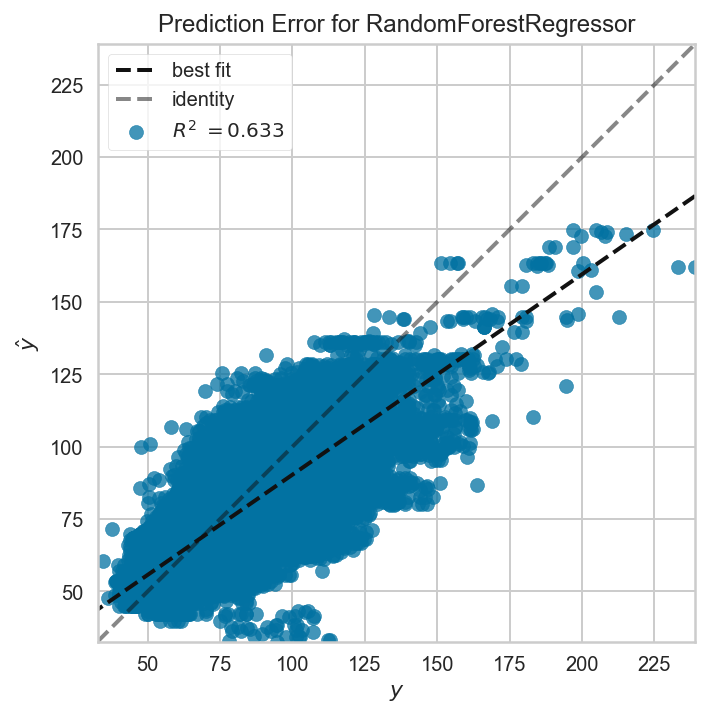

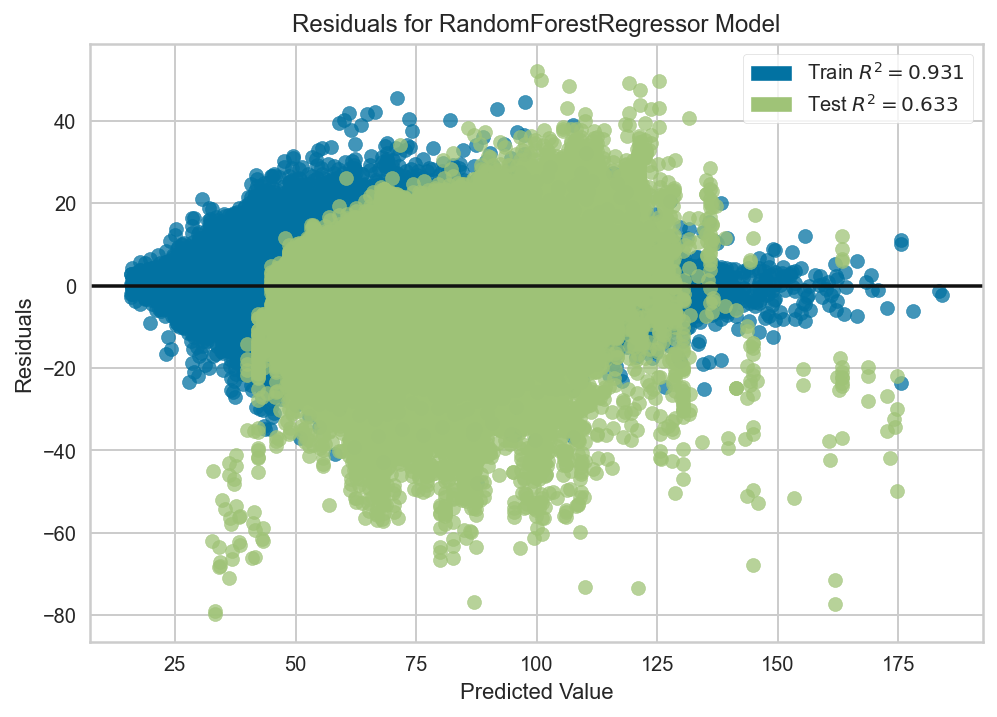

In [290]:
model_6(df_ml_3)

<br><br>

<br><br>

### We need to tune hyper-parameters to stop overfitting...

*THIS IS IMPORTANT TO DO RIGHT*

In [310]:

def grid_search_model(df):
    
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=1, 
                               criterion='mse',
                               n_estimators=100,
                               n_jobs=-1)   
    
    # rfModel = rf.fit(X_train, y_train)
    
#     y_pred_test = rfModel.predict(X_test)
#     y_pred_train = rfModel.predict(X_train)
#     y_pred_val = rfModel.predict(X_val)
    
#     print('\n')
#     print('--- Test Set ---')
#     print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
#     print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
#     print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
#     print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
#     print('Score ..................', rfModel.score(X_test, y_test))
#     print('--- Val Set ---')
#     print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
#     print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
#     print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
#     print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
#     print('Score ..................', rfModel.score(X_val, y_val))
#     print('--- Train Set ---')
#     print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
#     print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
#     print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
#     print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
#     print('Score ..................', rfModel.score(X_train, y_train))
#     print('\n')

    #     visualizer = PredictionError(rfModel, hist=False)
    #     visualizer.fit(X_train, y_train)
    #     visualizer.score(X_test, y_test)
    #     visualizer.poof()
    #     visualizer2 = ResidualsPlot(rfModel, hist=False)
    #     visualizer2.fit(X_train, y_train)  
    #     visualizer2.score(X_test, y_test)
    #     visualizer2.poof()

    
    #   Min Samples Leaf: 1–60

    #   Max Features: 0.1–1.0
    
    param_grid = [
    {   # 'n_estimators': [10, 20], 
          #      'max_features': [0.2, 0.4]    #  0.6, 0.8, 1.0], 
          'max_depth': [4,5,6,7,8],
          # 'min_samples_leaf': [10, 20, 30, 40, 50]
          # 'bootstrap': [True, False]} 
    }]
    
    grid_search_rf = GridSearchCV(estimator = rf, 
                                  param_grid = param_grid, 
                                  cv=5, 
                                  n_jobs = -1,
                                  verbose=1,
                                  return_train_score=True,
                                  # scoring='neg_mean_squared_error'
                                  )
    
    grid_search_rf.fit(X_train, y_train)
    
    cvres = grid_search_forest.cv_results_
    
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
    
    #find the best model of grid search
    print('Best:')
    print(grid_search_rf.best_estimator_)
    
    print('Best Parms:')
    print(grid_search_rf.best_params_)
    

In [311]:

grid_search_model(df_ml_3)

# --- Test Set ---
# Mean Absolute Error: ... 8.36483037097664
# Mean Squared Error:..... 130.53
# RMSE: .................. 11.425164080573788
# Coeff of det (R^2):..... 0.633
# Score .................. 0.6325333027861018
# --- Val Set ---
# Mean Absolute Error: ... 6.107622067257306
# Mean Squared Error:..... 72.91
# RMSE: .................. 8.538690998417009
# Coeff of det (R^2):..... 0.807
# Score .................. 0.8069477816917059
# --- Train Set ---
# Mean Absolute Error: ... 2.5799769958716667
# Mean Squared Error:..... 14.41
# RMSE: .................. 3.7966178831363036
# Coeff of det (R^2):..... 0.931
# Score .................. 0.9309251476030125



# 6.135952513703719 {'max_features': 5, 'n_estimators': 10}
# 6.068959633342858 {'max_features': 5, 'n_estimators': 20}
# 6.108645920244199 {'max_features': 10, 'n_estimators': 10}
# 6.030829315398504 {'max_features': 10, 'n_estimators': 20}
# Best:

# RandomForestRegressor(criterion='mse', max_features=10, n_estimators=20,
#                       n_jobs=-1, random_state=42)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [313]:
df_ml_3.to_pickle('use_this_data_for_gridsearch.pkl')

---

In [315]:
df_ml_3.head(1).T

,0
flat_model_2-Room,0.00
flat_model_Adjoined Flat,0.00
flat_model_Apartment,0.00
flat_model_Dbss,0.00
flat_model_Improved,1.00
flat_model_Improved-Maisonette,0.00
flat_model_Maisonette,0.00
flat_model_Model A,0.00
flat_model_Model A-Maisonette,0.00
flat_model_Model A2,0.00


In [316]:
df_ml_3.tail(1).T

,863976
flat_model_2-Room,0.00
flat_model_Adjoined Flat,0.00
flat_model_Apartment,0.00
flat_model_Dbss,0.00
flat_model_Improved,0.00
flat_model_Improved-Maisonette,0.00
flat_model_Maisonette,0.00
flat_model_Model A,1.00
flat_model_Model A-Maisonette,0.00
flat_model_Model A2,0.00
